In [41]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsforecast.models import SeasonalNaive, WindowAverage, AutoARIMA
from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mae
from statsforecast import StatsForecast

In [28]:
tickers = ['AAPL', 'AMZN', 'GOOGL', 'META']
stock_data = yf.download(tickers, start = '2025-01-01', end = '2026-01-01')
print(stock_data.head())

[*********************100%***********************]  4 of 4 completed

Price            Close                                            High  \
Ticker            AAPL        AMZN       GOOGL        META        AAPL   
Date                                                                     
2025-01-02  242.752106  220.220001  188.691010  597.356323  247.978468   
2025-01-03  242.264297  224.190002  191.041779  602.729309  243.080598   
2025-01-06  243.896912  227.610001  196.101990  628.218994  246.216423   
2025-01-07  241.119492  222.110001  194.727386  615.947693  244.444450   
2025-01-08  241.607269  222.130005  193.193375  608.800232  242.612732   

Price                                                  Low              \
Ticker            AMZN       GOOGL        META        AAPL        AMZN   
Date                                                                     
2025-01-02  225.149994  191.250991  603.008483  240.731247  218.190002   
2025-01-03  225.360001  192.456252  607.583995  240.800915  221.619995   
2025-01-06  228.839996  197.446729  6

In [29]:
print(stock_data.columns)

MultiIndex([( 'Close',  'AAPL'),
            ( 'Close',  'AMZN'),
            ( 'Close', 'GOOGL'),
            ( 'Close',  'META'),
            (  'High',  'AAPL'),
            (  'High',  'AMZN'),
            (  'High', 'GOOGL'),
            (  'High',  'META'),
            (   'Low',  'AAPL'),
            (   'Low',  'AMZN'),
            (   'Low', 'GOOGL'),
            (   'Low',  'META'),
            (  'Open',  'AAPL'),
            (  'Open',  'AMZN'),
            (  'Open', 'GOOGL'),
            (  'Open',  'META'),
            ('Volume',  'AAPL'),
            ('Volume',  'AMZN'),
            ('Volume', 'GOOGL'),
            ('Volume',  'META')],
           names=['Price', 'Ticker'])


In [30]:
print(stock_data.index)

DatetimeIndex(['2025-01-02', '2025-01-03', '2025-01-06', '2025-01-07',
               '2025-01-08', '2025-01-10', '2025-01-13', '2025-01-14',
               '2025-01-15', '2025-01-16',
               ...
               '2025-12-17', '2025-12-18', '2025-12-19', '2025-12-22',
               '2025-12-23', '2025-12-24', '2025-12-26', '2025-12-29',
               '2025-12-30', '2025-12-31'],
              dtype='datetime64[ns]', name='Date', length=250, freq=None)


In [31]:

stock_data = stock_data.loc[:, 'High']
stock_data = stock_data.reset_index()
stock_data = stock_data.rename(columns = {'Date' : 'ds'})
stock_data.head()

Ticker,ds,AAPL,AMZN,GOOGL,META
0,2025-01-02,247.978468,225.149994,191.250991,603.008483
1,2025-01-03,243.080598,225.360001,192.456252,607.583995
2,2025-01-06,246.216423,228.839996,197.446729,629.006489
3,2025-01-07,244.444450,228.380005,200.215886,630.112985
4,2025-01-08,242.612732,223.520004,195.524242,614.502283


In [32]:

stock_data = stock_data.melt(id_vars = ['ds'], var_name = 'unique_id', value_name = 'y')
stock_data.head()

,ds,unique_id,y
0,2025-01-02,AAPL,247.978468
1,2025-01-03,AAPL,243.080598
2,2025-01-06,AAPL,246.216423
3,2025-01-07,AAPL,244.444450
4,2025-01-08,AAPL,242.612732


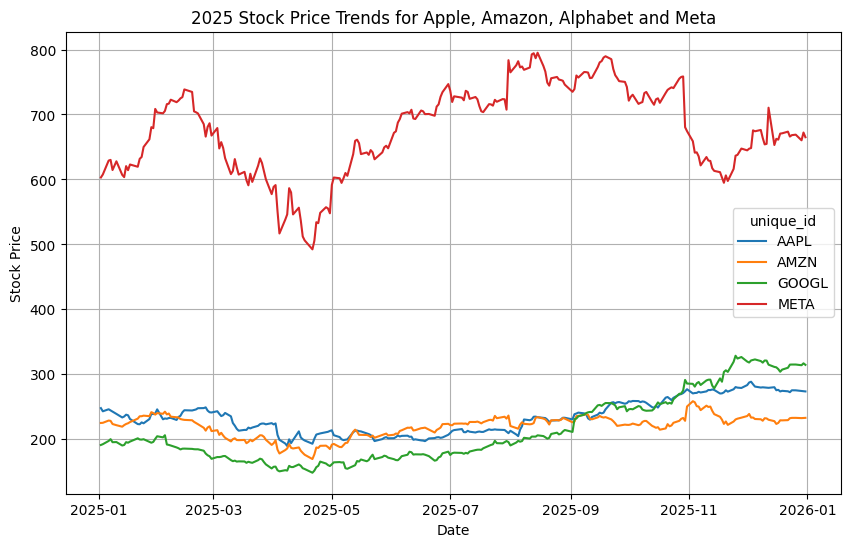

In [33]:
# Plot change of Apple stock price in 2025
plt.figure(figsize = (10, 6))
sns.lineplot(x = stock_data['ds'], y = stock_data['y'], hue = stock_data['unique_id'])
plt.title('2025 Stock Price Trends for Apple, Amazon, Alphabet and Meta')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.grid(True)
plt.show()

In [36]:
horizon = 20

models = [
    WindowAverage(window_size = 30),
    SeasonalNaive(season_length = 7),
    AutoARIMA(seasonal = False, alias = 'ARIMA'),
    AutoARIMA(season_length = 7, alias = 'SARIMA')
]

In [37]:
sf = StatsForecast(models = models, freq = 'D')

train_df = stock_data.loc[stock_data['ds'] < '2025-12-01', :]

test_df = stock_data.loc[stock_data['ds'] >= '2025-12-01', :]

cv_df = sf.cross_validation(
    h = horizon,
    df = train_df,
    n_windows = 11,
    step_size = horizon
)

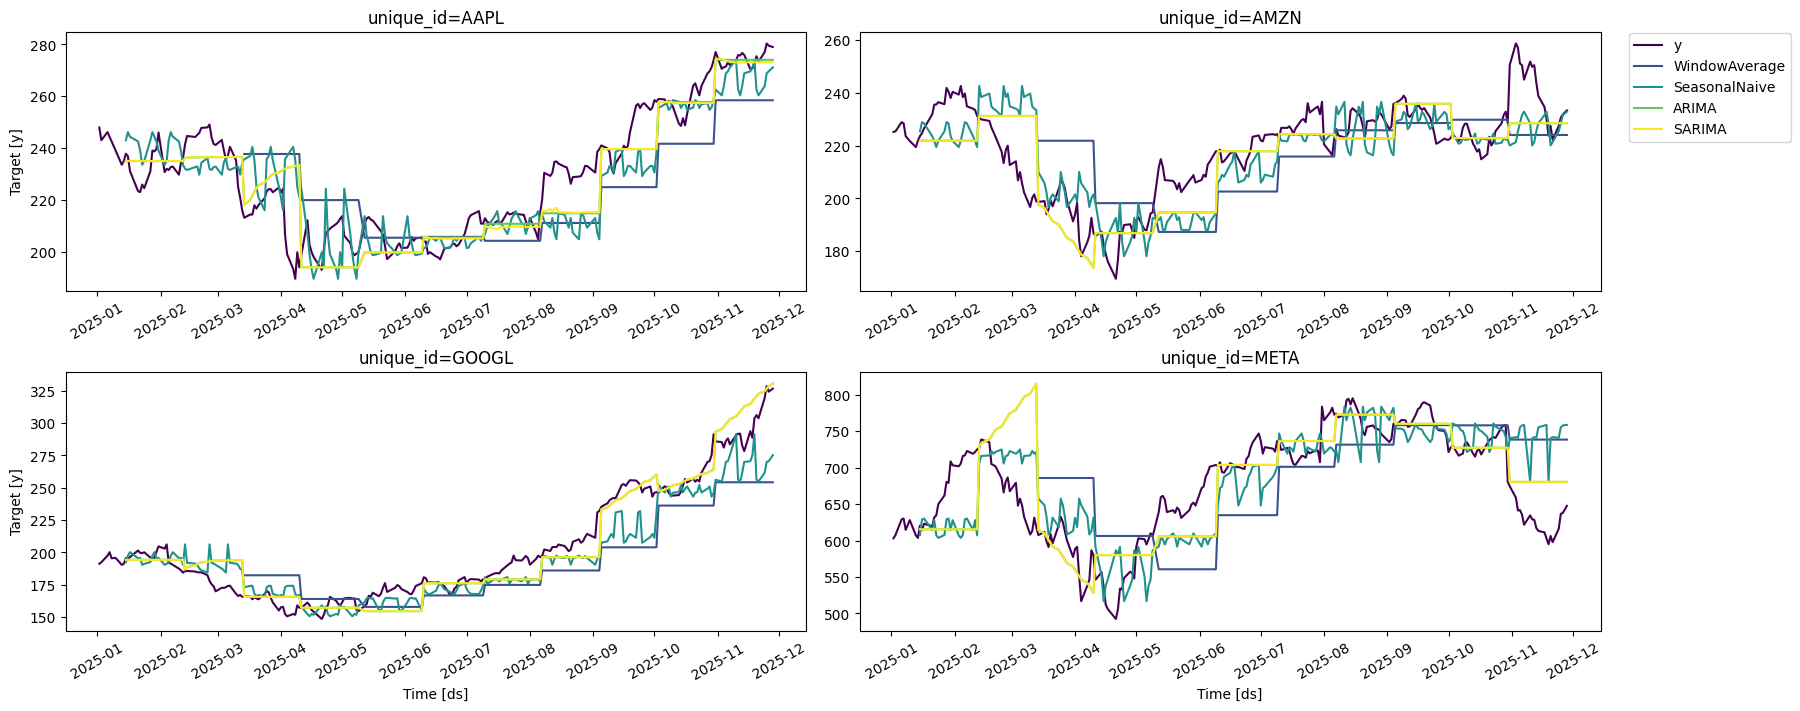

In [38]:
plot_series(
    df = train_df,
    forecasts_df = cv_df.drop(["y", "cutoff"], axis = 1),
    ids = ['AAPL', 'AMZN', 'GOOGL', 'META'],
    palette = "viridis"
)

In [42]:
eval_df = evaluate(cv_df.drop(["cutoff"], axis = 1), metrics = [mae])

eval_df = eval_df.drop(["unique_id"], axis = 1).groupby("metric").mean().reset_index()

eval_df.head()

,metric,WindowAverage,SeasonalNaive,ARIMA,SARIMA
0,mae,27.468471,19.815883,15.891143,15.902112


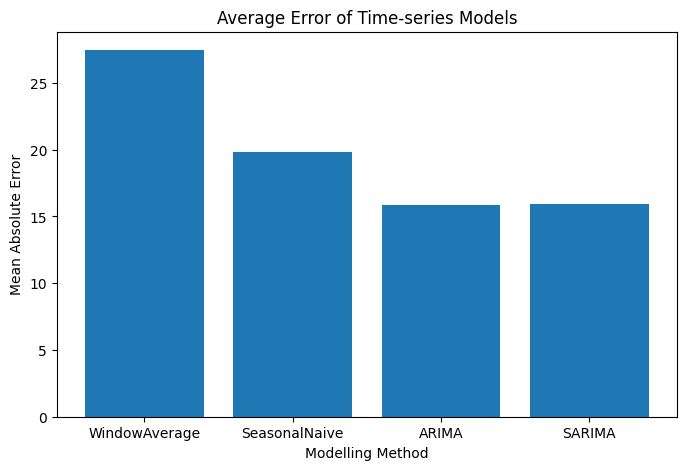

In [43]:
plt.figure(figsize = (8, 5))
plt.bar(eval_df.columns[1:], eval_df.iloc[0, 1:])

plt.xlabel('Modelling Method')
plt.ylabel('Mean Absolute Error')
plt.title('Average Error of Time-series Models')

plt.show()